# Classification
## Architecture of Neural Network Classification

| Hyperparameter              | Binary Classification                                                                 | Multiclass Classification                                                                 |
|-----------------------------|---------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| Input layer shape (in_features) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification                                                             |
| Hidden layer(s)             | Problem specific, minimum = 1, maximum = unlimited                                    | Same as binary classification                                                             |
| Neurons per hidden layer    | Problem specific, generally 10 to 512                                                 | Same as binary classification                                                             |
| Output layer shape (out_features) | 1 (one class or the other)                                                       | 1 per class (e.g. 3 for food, person or dog photo)                                        |
| Hidden layer activation     | Usually ReLU (rectified linear unit) but can be many others                           | Same as binary classification                                                             |
| Output activation           | Sigmoid (torch.sigmoid in PyTorch)                                                    | Softmax (torch.softmax in PyTorch)                                                        |
| Loss function               | Binary crossentropy (torch.nn.BCELoss in PyTorch)                                     | Cross entropy (torch.nn.CrossEntropyLoss in PyTorch)                                      |
| Optimizer                   | SGD (stochastic gradient descent), Adam (see torch.optim for more options)            | Same as binary classification                                                             |

## Generate Dataset with Scikit Learn

In [16]:
## generate dataset
# import SciKit Learn
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.05, random_state=42)

print("first 5 generated samples: ", X[:5])
print("first 5 integer labels: ", y[:5])

# size of the dataset
print("size of the dataset: ", X.shape, y.shape)

## Visualize data
# make dataframe
import pandas as pd
circles = pd.DataFrame({"x1": X[:,0], "x2": X[:,1], "label": y})
circles.head(10)

first 5 generated samples:  [[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]
first 5 integer labels:  [1 1 1 1 0]
size of the dataset:  (1000, 2) (1000,)


,x1,x2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


In [7]:
# check the number of different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

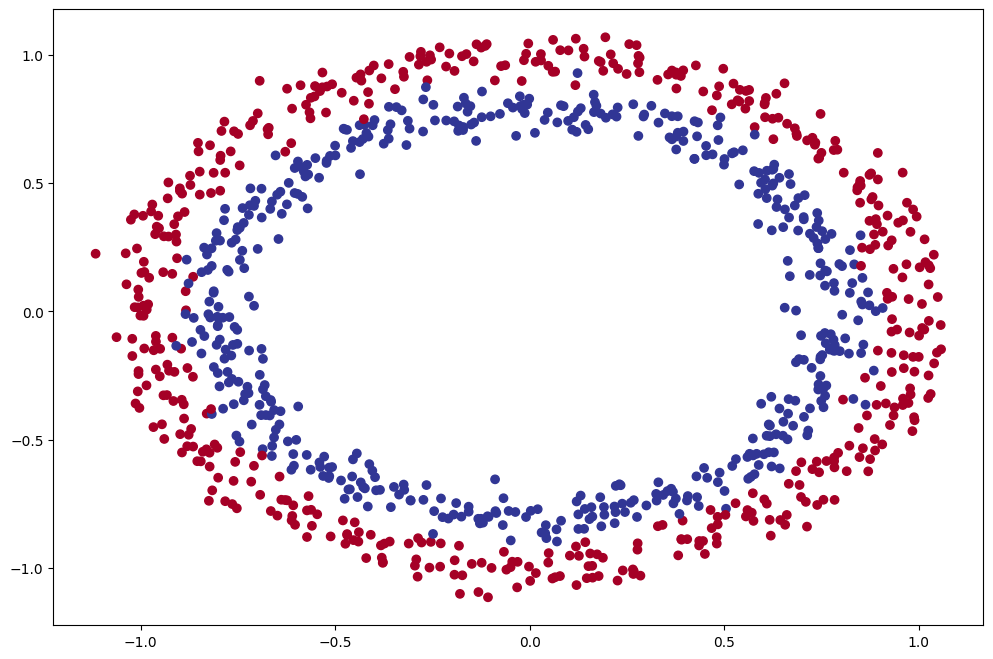

In [8]:
# plot the data
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

## Turn Data into Tensor and Create Train and Test Splits

In [14]:
# import PyTorch
import torch

# check torch version
print(torch.__version__)

# check data type
type(X), X.dtype

2.6.0.dev20241119


(torch.Tensor, torch.float64)

In [19]:
# convert data to tensor
X_tensor = torch.from_numpy(X) # shall the type of values be converted to float32??
y_tensor = torch.from_numpy(y)

type(X_tensor), X_tensor.dtype

(torch.Tensor, torch.float64)

In [23]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)